In [1]:
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel
from datasets import Dataset, load_dataset
import pandas as pd
import numpy as np
import random

seed = 2610
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/grad-min/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_ckpt = 'neulab/codebert-c'
#model_ckpt = 'neulab/codebert-cpp'
#model_ckpt = 'Salesforce/codet5p-110m-embedding'
#model_ckpt = 'microsoft/unixcoder-base'
#model_ckpt = 'codesage/codesage-small'
#model_ckpt = 'FacebookAI/roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt, trust_remote_code=True).to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at neulab/codebert-c and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# specify the file path here
file_path = 'full_data.csv'
data = pd.read_csv(file_path)

In [4]:
comment_regex = r'(//[^\n]*|\/\*[\s\S]*?\*\/)'
newline_regex = '\n{1,}'
whitespace_regex = '\s{2,}'

def data_cleaning(inp, pat, rep):
  return re.sub(pat, rep, inp)

data['truncated_code'] = (data['code'].apply(data_cleaning, args=(comment_regex, ''))
                                      .apply(data_cleaning, args=(newline_regex, ' '))
                                      .apply(data_cleaning, args=(whitespace_regex, ' '))
                         )
# remove all data points that have more than 15000 characters
length_check = np.array([len(x) for x in data['truncated_code']]) > 15000
data = data[~length_check]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test_valid, y_train, y_test_valid = train_test_split(data.loc[:, data.columns != 'label'],
                                                                data['label'],
                                                                train_size=0.8,
                                                                stratify=data['label']
                                                               )
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid.loc[:, X_test_valid.columns != 'label'],
                                                    y_test_valid,
                                                    test_size=0.5,
                                                    stratify=y_test_valid)

In [6]:
data_train = X_train
data_train['label'] = y_train
data_test = X_test
data_test['label'] = y_test
data_valid = X_valid
data_valid['label'] = y_valid

In [7]:
from datasets import Dataset, DatasetDict
#dts = Dataset.from_pandas(data)
dts = DatasetDict()
dts['train'] = Dataset.from_pandas(data_train)
dts['test'] = Dataset.from_pandas(pd.concat([data_test, data_valid]))
dts['valid'] = Dataset.from_pandas(pd.concat([data_test, data_valid]))

In [8]:
def tokenizer_func(examples):
      result = tokenizer(examples['truncated_code'])
      return result

dts = dts.map(tokenizer_func, batched=True, batch_size=4)

Map: 100%|██████████| 5440/5440 [00:04<00:00, 1279.72 examples/s]


In [10]:
model_ckpt

'neulab/codebert-c'

In [ ]:
dts.set_format('torch')
dts.rename_column('label', 'labels')
dts = dts.remove_columns(['code', 'truncated_code', '__index_level_0__'])

In [12]:
import torch.nn as nn
import torch
from transformers import AutoModel
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1, padding_idx=0):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # define embedding layers for encoding positions
        self.pos_encoding = nn.Embedding(max_len, d_model, padding_idx=padding_idx)
        
    def forward(self, x):
        device = x.device
        chunk_size, B, d_model = x.shape
        position_ids = torch.arange(0, chunk_size, dtype=torch.int).unsqueeze(1).to(device)
        position_enc = self.pos_encoding(position_ids) # (chunk_size, 1, d_model)
        position_enc = position_enc.expand(chunk_size, B, d_model)
        
        # Add positional encoding to the input token embeddings
        x = x + position_enc
        x = self.dropout(x)
        
        return x
    
class CodeBertModel(nn.Module):
    def __init__(self, 
                 max_seq_length: int = 512, 
                 chunk_size: int = 512, 
                 n_attn_head: int = 2,
                 dim_feedforward: int = 768,
                 padding_idx: int = 0,
                 model_ckpt: str = 'Salesforce/codet5p-110m-embedding'
                 ):
        super().__init__()
        self.embedding_model = AutoModel.from_pretrained(model_ckpt, trust_remote_code=True)
        
        dict_config = self.embedding_model.config.to_dict()
        for sym in ['hidden_dim', 'embed_dim', 'hidden_size']:
            if sym in dict_config.keys():
                embed_dim = dict_config[sym]
                
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim,
                                                   nhead=n_attn_head,
                                                   dim_feedforward=dim_feedforward,
                                                   batch_first=False)
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layer,
                                                         num_layers=2,
                                                         )

        self.positional_encoding = PositionalEncoding(max_len=max_seq_length, 
                                                      d_model=embed_dim, 
                                                      padding_idx=padding_idx)
        
        self.loss_func = nn.CrossEntropyLoss(weight=torch.Tensor([1.0, 3.0]),
                                             label_smoothing=0.2)
        
        self.ffn = nn.Sequential(nn.Dropout(p=0.1),
                                 nn.Linear(embed_dim, 2)
                                 )
        self.chunk_size = chunk_size

    def prepare_chunk(self, input_ids: torch.Tensor, 
                            attention_mask: torch.Tensor,
                            labels=None):
        """
        Prepare inputs into chunks that self.embedding_model can process (length < context_length)
        Shape info:
        - input_ids: (B, L)
        - attention_mask: (B, L)
        """
        
        device = input_ids.device
        # calculate number of chunks
        num_chunk = input_ids.shape[-1] // self.chunk_size
        if input_ids.shape[-1] % self.chunk_size != 0:
            num_chunk += 1
            pad_len = self.chunk_size - (input_ids.shape[-1] % self.chunk_size)
        else: 
            pad_len = 0
        
        B = input_ids.shape[0]
        # get the model's pad_token_id
        pad_token_id = self.embedding_model.config.pad_token_id
        
        # create a pad & zero tensor, then append it to the input_ids & attention_mask tensor respectively
        pad_tensor = torch.Tensor([pad_token_id]).expand(input_ids.shape[0], pad_len).int().to(device)
        zero_tensor = torch.zeros(input_ids.shape[0], pad_len).int().to(device)
        padded_input_ids = torch.cat([input_ids, pad_tensor], dim = -1).T # (chunk_size * num_chunk, B)
        padded_attention_mask = torch.cat([attention_mask, zero_tensor], dim = -1).T # (chunk_size * num_chunk, B)
                                                         
        chunked_input_ids = padded_input_ids.reshape(num_chunk, self.chunk_size, B).permute(0, 2, 1) # (num_chunk, B, chunk_size)
        chunked_attention_mask = padded_attention_mask.reshape(num_chunk, self.chunk_size, B).permute(0, 2, 1) # (num_chunk, B, chunk_size)
        
        pad_chunk_mask = self.create_chunk_key_padding_mask(chunked_input_ids)
        
        return chunked_input_ids, chunked_attention_mask, pad_chunk_mask
    
    def create_chunk_key_padding_mask(self, chunks):
        """
        If a chunk contains only pad tokens, ignore that chunk
        chunks: B, num_chunk, chunk_size
        """
        pad_token_id = self.embedding_model.config.pad_token_id
        pad_mask = (chunks == pad_token_id)
        
        num_pad = (torch.sum(pad_mask, -1) == self.chunk_size).permute(1, 0) # (num_chunk, B)
        
        return num_pad
    
    def forward(self, input_ids, attention_mask, labels=None):
        
        # calculate numbers of chunk
        chunked_input_ids, chunked_attention_mask, pad_chunk_mask = self.prepare_chunk(input_ids, attention_mask) # (num_chunk, B, chunk_size), (num_chunk, B, chunk_size), (num_chunk, B)
        
        # reshape input_ids & attention_mask tensors to fit into embedding model
        num_chunk, B, chunk_size = chunked_input_ids.shape
        chunked_input_ids, chunked_attention_mask = chunked_input_ids.contiguous().view(-1, chunk_size), chunked_attention_mask.contiguous().view(-1, self.chunk_size) # (B * num_chunk, chunk_size), (B * num_chunk, chunk_size)
        
        # roberta-exclusive
        embedded_chunks = (self.embedding_model(input_ids = chunked_input_ids,
                                                attention_mask = chunked_attention_mask)['pooler_output'] # (B * num_chunk, self.embedding_model.config.hidden_dim)
                               .view(num_chunk, B, -1) # (num_chunk, B, self.embedding_model.config.hidden_dim)
                          )
        
        # embedded_chunks = (self.embedding_model(input_ids = chunked_input_ids,
        #                                         attention_mask = chunked_attention_mask) # (B * num_chunk, self.embedding_model.config.hidden_dim)
        #                        .view(num_chunk, B, -1) # (num_chunk, B, self.embedding_model.config.hidden_dim)
        #                   )
        
        # embedded_chunks = self.positional_encoding(embedded_chunks)
        
        # output = self.transformer_encoder(embedded_chunks, 
        #                                   src_key_padding_mask = pad_chunk_mask) # (num_chunk, B, self.embedding_model.config.hidden_dim)
        
        # logits = self.ffn(output[0])
        chunk_mean = torch.mean(embedded_chunks, 0)
        logits = self.ffn(chunk_mean)
        
        if labels is not None:
            loss = self.loss_func(logits, labels)
            return {"loss": loss, "logits": logits}
        
        return {"logits": logits}

In [13]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
def compute_metrics(eval_pred):
    y_pred, y_true = np.argmax(eval_pred.predictions, -1), eval_pred.label_ids
    return {'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred)}

In [14]:
model = CodeBertModel(model_ckpt=model_ckpt,
                      n_attn_head=8)

Some weights of RobertaModel were not initialized from the model checkpoint at neulab/codebert-c and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/grad-min/.local/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [15]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_arguments = TrainingArguments(output_dir = 'my_codeberta',
                                      evaluation_strategy = 'epoch',
                                      per_device_train_batch_size = 2,
                                      per_device_eval_batch_size = 2,
                                      gradient_accumulation_steps = 12,
                                      learning_rate = 2e-5,
                                      num_train_epochs = 3,
                                      warmup_ratio = 0.1,
                                      lr_scheduler_type = 'cosine',
                                      logging_strategy = 'steps',
                                      logging_steps = 10,
                                      save_strategy = 'no',
                                      fp16 = True,
                                      metric_for_best_model = 'recall',
                                      optim = 'adamw_torch',
                                      report_to = 'none'
                                      )
trainer = Trainer(model=model,
                  data_collator=data_collator,
                  args=training_arguments,
                  train_dataset=dts['train'],
                  eval_dataset=dts['valid'],
                  compute_metrics=compute_metrics,
                 )

/home/grad-min/.local/lib/python3.8/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
#import wandb
#wandb.init()
trainer.train()
#wandb.finish()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.647100,0.655965,0.509007,0.480703,0.959274,0.640463
1,0.611400,0.638768,0.577206,0.520747,0.910887,0.662658
2,0.624400,0.640001,0.604963,0.541825,0.864516,0.666149


TrainOutput(global_step=2718, training_loss=0.6486820251824138, metrics={'train_runtime': 1400.4906, 'train_samples_per_second': 46.612, 'train_steps_per_second': 1.941, 'total_flos': 0.0, 'train_loss': 0.6486820251824138, 'epoch': 2.997794117647059})

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = trainer.predict(dts['test'])
y_true = dts['test']['label']

In [94]:
y_pred = y_pred.predictions.argmax(-1).tolist()
y_true = y_true

AttributeError: 'list' object has no attribute 'predictions'

In [95]:
y_true = y_true.tolist()

In [101]:
conf = confusion_matrix(y_true, y_pred)

In [106]:
conf

array([[1246, 1714],
       [ 310, 2170]])

<Axes: >

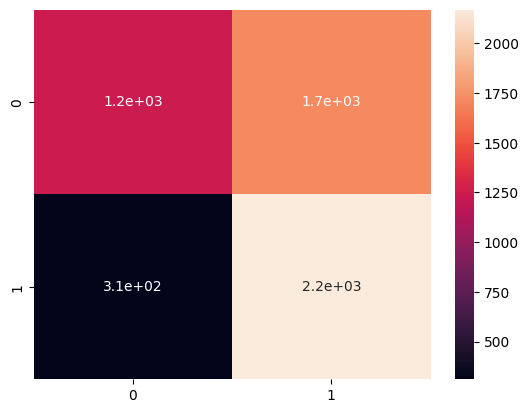

In [105]:
import seaborn as sns
sns.heatmap(conf, annot=True)

In [104]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     |████████████████████████████████| 294 kB 40.1 MB/s eta 0:00:01
